# Problem Session 6

The problems in this notebook will cover the content covered in our Inference II lectures including:
- Bootstapping
- Model Specification Testing

In [1]:
import numpy as np
import pandas as pd

#### 1.  Bootstrapping vs ANOVA

We introduce a new dataset which records the following variables for 200 students:

* `read`: Score on a reading test
* `math`: Score on a math test
* `prog`: Categorical variable indicating program of study
    * Takes values `vocational`, `general`, `academic`
* `gre`:  The score on the GRE

In [2]:
df = pd.read_csv("https://stats.idre.ucla.edu/stat/data/tobit.csv", names = ['id','read', 'math', 'prog', 'gre'], header = 0, index_col= 'id')
df.head()

,read,math,prog,gre
id,,,,
1,34,40,vocational,352
2,39,33,vocational,449
3,63,48,general,648
4,44,41,general,501
5,47,43,general,762


##### (a) Exploratory Data Analysis

Do a little EDA.  Some ideas include:

* Comparing mean GRE score across different program types.
* Plotting GRE against both "read" and "math" scores, perhaps colored using program type.

Is there any other EDA you can think of?

Did you notice anything interesting in your EDA?

In [3]:
# Comparing mean GRE score by program type

df.groupby('prog').gre.mean()

prog
academic      639.022222
general       677.761905
vocational    561.720000
Name: gre, dtype: float64

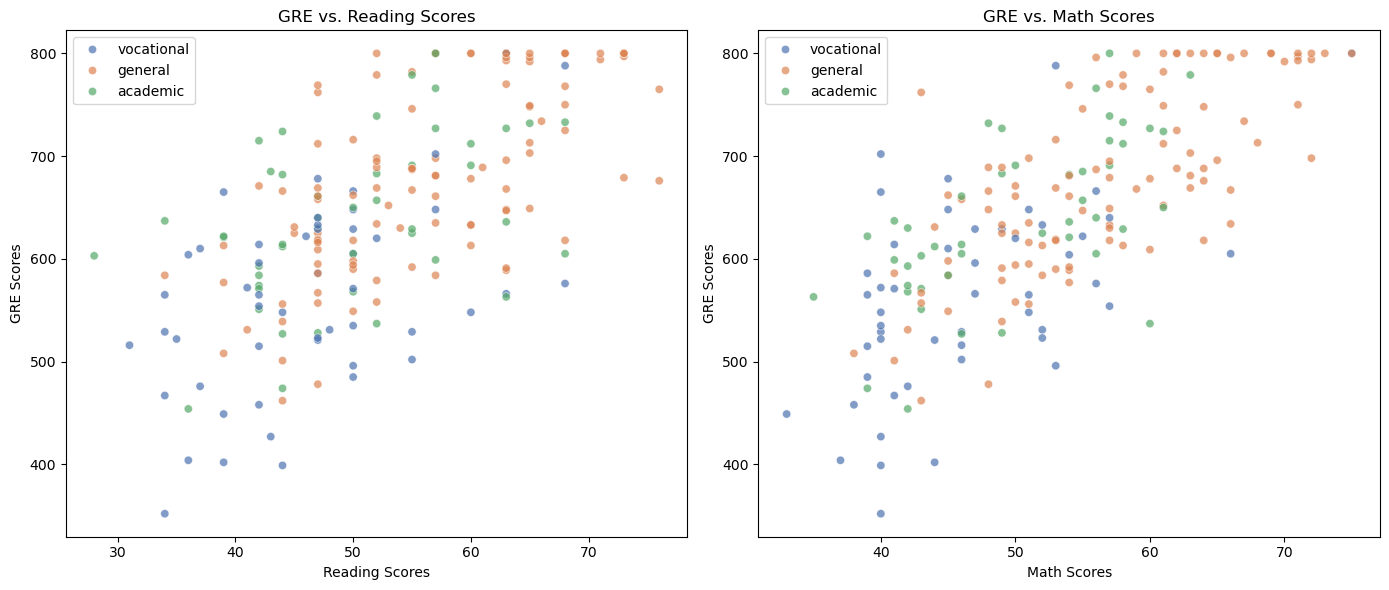

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Scatter plot for GRE vs. Reading Scores
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='read', y='gre', hue='prog', palette='deep', alpha=0.7)
plt.title('GRE vs. Reading Scores')
plt.xlabel('Reading Scores')
plt.ylabel('GRE Scores')
plt.legend()

# Scatter plot for GRE vs. Math Scores
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='math', y='gre', hue='prog', palette='deep', alpha=0.7)
plt.title('GRE vs. Math Scores')
plt.xlabel('Math Scores')
plt.ylabel('GRE Scores')
plt.legend()

plt.tight_layout()
plt.show()


##### (b) ANOVA

The mean GRE score for each program type look different, but is this a statistically significant difference?

As mentioned in the Linear Regression Inference lecture, one-way ANOVA is the same as an F-test comparing the two nested models

$$
\begin{align*}
\textrm{Reduced Model: }\textrm{GRE} &= \beta_0 + \epsilon\\
\textrm{Full Model: }\textrm{GRE} &= \beta_0 + \beta_1 \textrm{Vocational} + \beta_2 \textrm{General} + \epsilon
\end{align*}
$$

The $p$-value of an $F$-test comparing the full model to the constant model is included in a `statsmodels model` summary.  So fit the full model to the data and see what you get!

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Hint:  C(prog) gives indicator variables for the levels of prog 
# with one omitted if a constant term is included in the model
model = ols('gre ~ C(prog)', data=df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gre   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     29.90
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           4.58e-12
Time:                        09:10:59   Log-Likelihood:                -1176.2
No. Observations:                 200   AIC:                             2358.
Df Residuals:                     197   BIC:                             2368.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               639.0222     13.020     49.079      0.000     613.345     664.699
C(prog)[T.general]       38.7397     15.562      2.489      0.014       8.050      69.430
C(prog)[T.vocational]   -77.3022     17.947     -4.307      0.000    -112.696     -41.909
==============================================================================
Omnibus:                        1.465   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                1.318
Skew:                          -0.050   Prob(JB):                        0.517
Kurtosis:                       2.615   Cond. No.                         4.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# Note:  If you would like a traditional "ANOVA table" you can get one like this.abs
# For statsmodels, ANOVA is just a special display 
# of a linear regression model with categorical variables

anova_table = sm.stats.anova_lm(model, typ=2)

# The F statistic and p-value are the same as we obtained in the model summary above.
print(anova_table)

                sum_sq     df          F        PR(>F)
C(prog)   4.561566e+05    2.0  29.896843  4.580003e-12
Residual  1.502882e+06  197.0        NaN           NaN


##### (c) Bootstrap confidence intervals

You should have obtained confidence intervals for the mean GRE score of each program type. 

We will now get confidence intervals by bootstrapping instead!

In [7]:
def bootstrap_ci(data, group_col, outcome_col, n_bootstrap=10000, ci=0.95):
    '''
    Inputs:
        data:  A pandas dataframe.
        group_col: The name of the column with the categorical variable.
        outcome_col:  The name of the column with the continuous outcome.
        n_bootstrap:  The number of bootstrap resamples.  We are resampling the rows of data.
        ci: The nominal coverage of confidence interval.
    
    Outputs:
        group_means:  A dictionary
            keys:  One key for each unique level of group_col
            values:  A tuple (original_mean, ci_lower, ci_upper)
                original_mean: The group outcome mean in the original sample.
                ci_lower:  Lower limit of the confidence interval.
                ci_upper:  Upper limit of the confidence interval.
    '''
    group_means = {}
    lower_percentile = (1 - ci) / 2
    upper_percentile = 1 - lower_percentile
    
    # Get unique groups
    groups = data[group_col].unique()
    
    # Perform percentile bootstrap for each group
    for group in groups:
        group_data = data[data[group_col] == group][outcome_col].values
        original_mean = np.mean(group_data)  # The original sample mean
        
        # Generate bootstrap samples and means
        bootstrap_samples = np.random.choice(group_data, (n_bootstrap, len(group_data)), replace=True)
        bootstrap_means = np.mean(bootstrap_samples, axis=1)
        
        
        # Calculate percentile confidence intervals
        ci_lower = np.percentile(bootstrap_means, (1 - upper_percentile) * 100)
        ci_upper = np.percentile(bootstrap_means, (1 - lower_percentile) * 100)
        
        group_means[group] = (original_mean, ci_lower, ci_upper)
    
    return group_means

bootstrap_results = bootstrap_ci(df, group_col='prog', outcome_col='gre')

# Print the bootstrap mean and confidence intervals for each group
for group, (mean, ci_lower, ci_upper) in bootstrap_results.items():
    print(f"Group: {group}, Mean: {mean:.2f}, 95% CI (Reverse Bootstrap): [{ci_lower:.2f}, {ci_upper:.2f}]")


Group: vocational, Mean: 561.72, 95% CI (Reverse Bootstrap): [535.46, 587.70]
Group: general, Mean: 677.76, 95% CI (Reverse Bootstrap): [660.98, 694.58]
Group: academic, Mean: 639.02, 95% CI (Reverse Bootstrap): [616.47, 661.51]


#### (2) Regression

In this problem we would like to regress `gre` on the other variables.  We *could* estimate this using vanilla OLS linear regression.  However the GRE has a maximum score of 800.  We can see that 17 of the students did actually achieve this score.  [This meme](https://www.youtube.com/shorts/Lb3lj4IhD0U) has a great point:  these students may have had an aptitude which was greater than what the test could measure.

One tool for estimating the regression coefficients in this circumstance is [Tobit Regression](https://en.wikipedia.org/wiki/Tobit_model).  The idea is that we should model the GRE score as being given by a latent response which is linear in the predictors.  This latent response is then censored at the upper limit of 800.  We then estimate the model parameters using maximum likelihood.

Unfortunately it doesn't seem that statsmodels (or any other Python library) contains an implementation.  So I implemented it from scratch by converting [Michael Clark's implementation in R](https://m-clark.github.io/models-by-example/tobit.html) to Python.

Note:  This shows why understanding theory can be important!  Sometimes you really do need to "roll your own" model.

You can check out the code for this TobitModel class which is found in  `tobit_model.py` in this folder.

Since this is a custom model the implementation is a bit idiosyncratic, and it is definitely not optimized for either speed or usability.  However it does reproduce the results which Michael Clark was getting using R!

In [8]:
from tobit_model import TobitModel
from sklearn.linear_model import LinearRegression

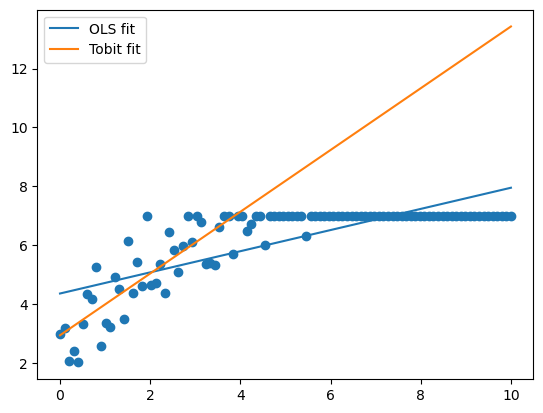

In [9]:
# Creating some synthetic censored data
X = np.linspace(0,10,100)
y = 3 + X + np.random.randn(100)
y = y * (y < 7) + 7 * (y > 7)

# Fitting OLS linear regression model
lr = LinearRegression()
lr.fit(X.reshape(-1,1),y)

# Fitting the Tobit model.  
# Notice what parameters are needed for initialization.
# ul is the (known) censoring upper limit.

# TobitModel requires a design matrix with an initial column of ones.
X_tb = np.ones((100,2))
X_tb[:,1] = X

tb = TobitModel(X = X_tb, y = y, ul = 7)
tb.fit()

plt.scatter(X, y)
plt.plot(X, lr.predict(X.reshape(-1,1)), label = 'OLS fit')
plt.plot(X, tb.predict(X_tb), label = 'Tobit fit')
plt.legend()

plt.show()

In [10]:
# [constant term, slope, log of variance]
tb.params_

array([2.94525718e+00, 1.04822708e+00, 1.00000000e-05])

As we can see, the OLS model is inappropriate for censored data while the Tobit model does fine!

##### (a)

Fit the Tobit model on the full dataset:

In [11]:
# Make dummy variables for general and vocational levels of prog
df['general'] = (pd.get_dummies(df.prog)*1.0).general
df['vocational'] = (pd.get_dummies(df.prog)*1.0).vocational

# Make a column of ones, needed for my implementation
df['constant'] = np.ones(len(df))

In [12]:
features = ['constant','read', 'math', 'general', 'vocational']

In [13]:
model = TobitModel(X= df[features], y=df.gre.values, ul = 800)

In [14]:
model.fit()

In [15]:
{features[i]: model.params_[i] for i in range(len(features))}

{'constant': 209.56513464753726,
 'read': 2.696787710922848,
 'math': 5.915723216654197,
 'general': -12.715032991958267,
 'vocational': -46.14897629075807}

##### (b) Bootstrapping confidence intervals for the conditional target means.

Since this model was not fit using ordinary least squares, the standard formula for the confidence intervals of conditional target means does not apply.  This is the kind of situation where bootstrapping really shines!

Complete the definition of the following function:

In [16]:
import numpy as np

def bs_conditional_mean(X_train, y_train, ul, X_cond, num_bootstrap_samples):
    '''
    Finds the 'reverse' bootstrap confidence interval for the conditional outcome means of a Tobit model.

    Inputs
    X_train:  A numpy array with initial column of ones.  Shape is (nobs, 1 + number of features).
    y_train:  A numpy array of shape (nobs,).
    ul: Upper limit for Tobit Model.
    X_cond:   Design matrix for the observations we want to condition on.
    num_bootstrap_samples:  Self-explanatory

    Outputs:
    (lower_bound, upper_bound)
    '''
    y_cond = np.zeros((X_cond.shape[0], num_bootstrap_samples))
    
    for i in range(num_bootstrap_samples):
        # sample the indices for bootstrap sampling
        sample_indices = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
        
        # Slice X_boot using sampled indices
        X_boot = X_train[sample_indices, :]
        y_boot = y_train[sample_indices]

        # Initialize and fit the Tobit model
        model = TobitModel(X = X_boot, y = y_boot, ul = ul)
        model.fit()

        # Store predictions for the conditional mean
        y_cond[:, i] = model.predict(X_cond)
    
    # Calculate the lower and upper bounds of the confidence intervals
    lower_bound = np.percentile(y_cond, 2.5, axis=1)
    upper_bound = np.percentile(y_cond, 97.5, axis=1)

    return lower_bound, upper_bound


Use this to find the confidence interval for the conditional mean GRE score for

* `read = 60`, `math = 70`, `prog = general`
* `read = 70`, `math = 40`, `prog = vocational`


In [17]:
X_cond = pd.DataFrame.from_dict({'constant':[1,1], 'read': [60,70],'math':[70,40], 'general': [1,0], 'vocational':[0,1]})

In [18]:
lower_ci, upper_ci = bs_conditional_mean(df[features].values, df.gre.values, 800, X_cond, 5)

In [19]:
# Confidence interval for mean GRE conditioned on `read = 60`, `math = 70`, `prog = general`
lower_ci[0], upper_ci[0]

(750.7139557068085, 784.8418570688)

In [20]:
# Confidence interval for mean GRE conditioned on `read = 70`, `math = 40`, `prog = vocational`

lower_ci[1], upper_ci[1]

(566.4889492768622, 617.1577215819411)

In [21]:
df[features]

,constant,read,math,general,vocational
id,,,,,
1,1.0,34,40,0.0,1.0
2,1.0,39,33,0.0,1.0
3,1.0,63,48,1.0,0.0
4,1.0,44,41,1.0,0.0
5,1.0,47,43,1.0,0.0
...,...,...,...,...,...
196,1.0,44,49,1.0,0.0
197,1.0,50,50,1.0,0.0
198,1.0,47,51,1.0,0.0
